# 4. Vision

[![](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/ArashAkbarinia/mbb/blob/main/notebooks/vision.ipynb)

In this notebook, we build on the [geometrical shape classification notebook](https://github.com/ArashAkbarinia/mbb/blob/main/notebooks/build_DNN_project.ipynb) that we studied a few weeks ago. The network's output for our classification problem was one label for the whole image. We change the code to implement *semantic segmentation* – one label per pixel.

We have to change:
 * **dataset**: to create ground truth for each pixel.
 * **network**: to output a matrix with the exact spatial resolution as input.

***
## 0. Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.
 * [cv2](https://docs.opencv.org/4.x/index.html) is a leading computer vision library.

In [1]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import random

import torch
import torch.nn as nn
import torchvision

import cv2

Choosing CPU or GPU based on the availability of the hardware.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

***

## 1. Dataset 

The first step is to get the data ready. In this tutorial, we create our dataset on the fly, i.e., we generate images containing simple geometrical shapes. Our dataset contains three types of shapes: 
 * circle
 * ellipse
 * rectangle
 
<span style="color:blue">**Update:**</span> All other pixels belong to the *background* category. 

In [3]:
labels_map = {
    0: 'background',
    1: "circle",
    2: "ellipse",
    3: "rectangle"
}
# we define a set of colours that help us to visualise the labels
labels_colours = {
    'background': [0, 0, 0],
    'circle': [255, 0, 0],
    'ellipse': [0, 255, 0],
    'rectangle': [0, 0, 255]
}

### dataset-utility functions.
First, we create all the utility functions to generate a set of images.
 * `create_random_background` simply creates a square matrix of size `(s, s, 3)`, the third dimension corresponds to RGB channels.
 * `create_random_shape` uses `cv2` functions to draw geometrical shapes on top of an image.
 
<span style="color:blue">**Update:**</span>
 * `create_random_shape` returns a matrix for the ground truth. Every pixel is labelled according to the object it belongs to.
 * `tile_img` divides an image into four tiles and calls `create_random_shape` to draw one shape on top of the background for each section.

In [4]:
def create_random_background(img_size, p=0.5):
    """This functions creates a background image."""
    # if the random value larger than 0.5, the background will be random noise, otherwise, random uniform
    if np.random.rand() > p:
        return np.random.randint(0, 256, (img_size, img_size, 3), dtype='uint8')
    else:
        return np.zeros((img_size, img_size, 3), dtype='uint8') + np.random.randint(0, 256, dtype='uint8')

def create_random_shape(img, filled):
    """This functions generates geometrical shapes on top of a background image."""
    # choosing a colour for the shape, there is a slim chance of being identical to the background,
    # we can consider this the noise in our dataset!
    colour = [random.randint(0, 255) for _ in range(3)]
    thickness = np.random.randint(2, 7)
    point1 = np.random.randint(img.shape[0] // 4, 3 * (img.shape[0] // 4), 2)
    
    # drawing a random geomterical shape, we start from 1, because category 0 belongs to background
    shape_ind = np.random.randint(1, len(labels_map))
    # when the tickness is negative, the shape is drawn filled
    thickness *= -1 if filled else np.random.choice([-1, 1])
    
    # the ground-truth in a single channel image with the same spatial resolusion as the input image 
    gt_mat = np.zeros(img.shape[:2], dtype=np.uint8)
    
    if shape_ind == 1: # circle
        radius = np.random.randint(10, img.shape[0] // 4)
        img = cv2.circle(img, point1, radius, color=colour, thickness=thickness)
        gt_mat = cv2.circle(gt_mat, point1, radius, color=shape_ind, thickness=thickness)
    elif shape_ind == 2: # ellipse
        axes = [
            np.random.randint(5, 10),
            np.random.randint(10, 20)
        ]
        angle = np.random.randint(0, 360)
        img = cv2.ellipse(img, point1, axes, angle, 0, 360, color=colour, thickness=thickness)
        gt_mat = cv2.ellipse(gt_mat, point1, axes, angle, 0, 360, color=shape_ind, thickness=thickness)
    else: # rectangle
        point2 = np.random.randint(0, img.shape[0], 2)
        img = cv2.rectangle(img, point1, point2, color=colour, thickness=thickness)
        gt_mat = cv2.rectangle(gt_mat, point1, point2, color=shape_ind, thickness=thickness)
    return img, gt_mat

def tile_img(img, filled):
    """Crops the image into tiles and draw a geometrical shape on top of each tile"""
    rows, cols, _ = img.shape
    # the ground-truth in a single channel image with the same spatial resolusion as the input image 
    gt_mat = np.zeros((rows, cols), dtype=np.uint8)
    num_grids = 2
    tile_rows = rows // num_grids
    tile_cols = cols // num_grids
    for i in range(0, rows, tile_rows):
        for j in range(0, cols, tile_cols):
            tile_img = img[i:i+tile_rows, j:j+tile_cols]
            tile_img, tile_gt = create_random_shape(tile_img, filled)
            gt_mat[i:i+tile_rows, j:j+tile_cols] = tile_gt
    return img, gt_mat

For visualisation purposes, it's useful to see all pixels belonging to the same category with the same colour. For example, all the rectangles in blue irrespective of their surface colour. Therefore we implement the `label2colour` function that loops through all the available labels in the image and colours them according to the colours we defined earlier.

In [5]:
def label2colour(gt_mat):
    """Colouring a label image for visualisation purposes"""
    coloured_img = np.zeros((*gt_mat.shape, 3), dtype=np.uint8)
    for label in np.unique(gt_mat):
        colour = labels_colours[labels_map[label]]
        coloured_img[gt_mat == label] = colour
    return coloured_img

### Dataset visualisation

Let's have a look at a few images that our dataset generates. We use `plt` from the `matplotlib` library to create a figure and a grid of $5 \times 5$ subplots. Each insert contains two images
 * The left image is the RGB image (network's input).
 * The right image is the coloured ground-truth image.
 
Note that:
 * In the RGB image, geometrical shapes and backgrounds can have an arbitrary colour.
 * In the ground-truth image, the background is always black, circles red, ellipses green, and rectangles blue. **This is just for visualisation and the ground truth to compute loss is the label number, 0 to 3 correspondingly**.

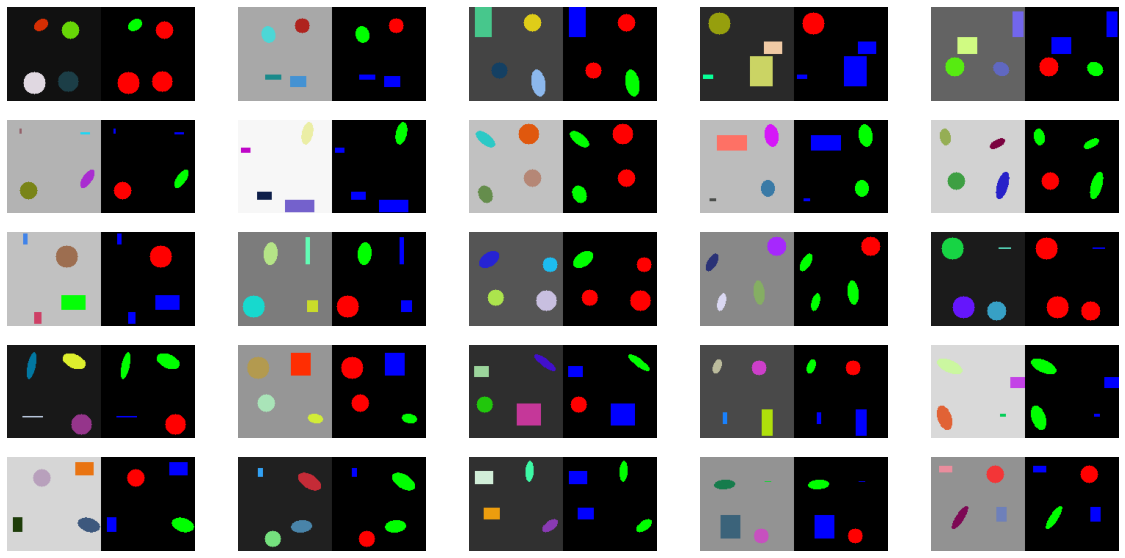

In [6]:
# definying the parametrs of the dataset
img_size = 128
filled = True # whether the geometrical shapes are only the contour or filled
bg_uniform_vs_noise = 1 # the probability of the backgroud being a uniform colour or a noisy image

# plot 25 of the images
fig = plt.figure(figsize=(20, 10))
for i in range(25):
    # retrieving a random image with its corresponding ground-truth
    img, gt = tile_img(create_random_background(img_size, bg_uniform_vs_noise), filled)
    ax = fig.add_subplot(5, 5, i+1)
    # concatanating the image with the coloured labels.
    ax.imshow(np.concatenate([img, label2colour(gt)], axis=1))
    ax.axis('off')

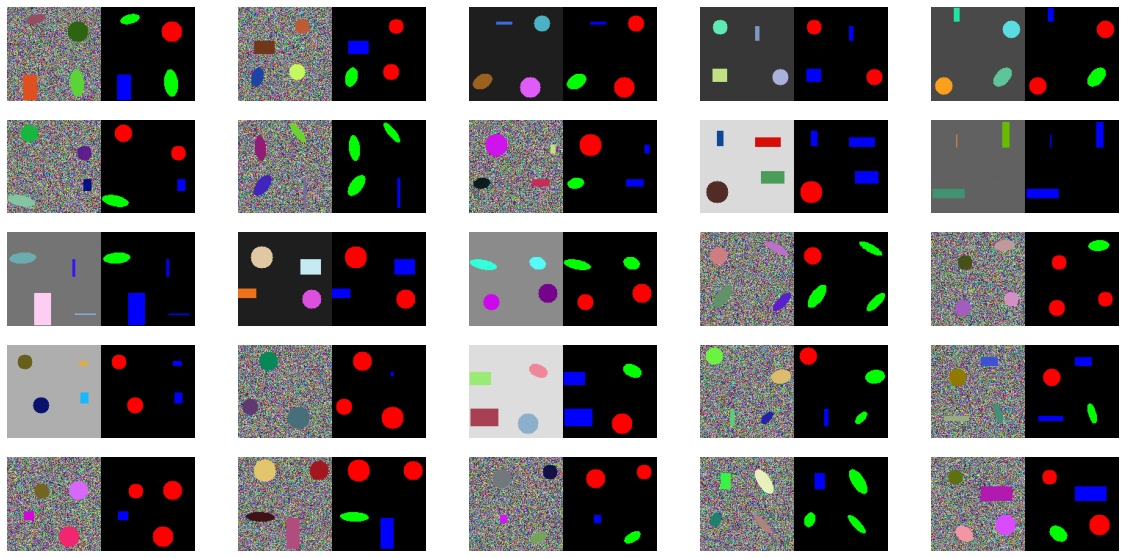

In [7]:
# definying the parametrs of the dataset
img_size = 128
filled = True # whether the geometrical shapes are only the contour or filled
bg_uniform_vs_noise = 0.5 # the probability of the backgroud being a uniform colour or a noisy image

# plot 25 of the images
fig = plt.figure(figsize=(20, 10))
for i in range(25):
    # retrieving a random image with its corresponding ground-truth
    img, gt = tile_img(create_random_background(img_size, bg_uniform_vs_noise), filled)
    ax = fig.add_subplot(5, 5, i+1)
    # concatanating the image with the coloured labels.
    ax.imshow(np.concatenate([img, label2colour(gt)], axis=1))
    ax.axis('off')

### PyTorch Data Pipeline

Now, that we have created our dataset, we have to create PyTorch dataloaders.

In this example, we're creating a simple dataloader class ```ShapeDataset``` that inherits the ```torch.utils.data.Dataset``` class. It has to implement two functions:
* ```__len__``` (return the number of samples in the dataset) 
* ```__getitem__``` that yield the approperiate data. 

Usually, the datasets used in deep-learning projects are huge (e.g., ImageNet contains 1.5 million images). Therefore, we cannot load all images in the memory and we read each image dynamically in the ```__getitem__``` function. 

One can create any sort of custom dataset with the same structure as our toy example. The initialisation function (`__init__`) receives all the necessary parameters to create a dataset. Usually, the passed variables are stored as class variables to use later on in the `__getitem__` function. Sometimes the `__init__` function has to prepare data paths, e.g., to read the name of all image files in a folder (**important** not the images themselves that are heavy for the memory but only their paths to load later).

The argument `transform` is typically part of any dataset. `transform` contains a predefined set of functions that are sequentially executed on an image. Typical examples of such functions include:
* Conversion to torch tensor
* Normalising the input image
* Data augmentations such as random cropping or flipping of an image.
* etc.

<span style="color:blue">**Update:**</span> given our dataset is grounded on random generated shapes, in this toy example:
* We can create the sample directly in the `__getitem__` functoin.
* We don't need data augmentation.

In [8]:
# PyTorch dataset
class ShapeDataset(torch.utils.data.Dataset):

    def __init__(self, num_imgs, target_size, bg_uniform_vs_noise, transform=None):
        self.num_imgs = num_imgs
        self.target_size = target_size
        self.bg_uniform_vs_noise = bg_uniform_vs_noise
        self.transform = transform

    def __len__(self):
        return self.num_imgs

    def __getitem__(self, _idx):
        # our routine doesn't need the idx, which is the sample number
        img, gt = tile_img(create_random_background(
            self.target_size, self.bg_uniform_vs_noise
        ), filled)

        if self.transform:
            img = self.transform(img)
        # ground truth should also be converted to tensor
        # the crossentropy loss expects the "long" data type
        gt = torch.tensor(gt).long()
        return img, gt

#### transform functions

In this toy example, we define only two necessary transformation functions:
 * `ToTensor` The data must be converted to torch tensors by calling the ```ToTensor``` function.
 * `Ǹormalize` Deep networks are trained better and faster when the data is centred at 0. For this reason, we apply the ```Normalize``` functions with specific ```mean``` and ```std```.
 
In our example we have only used the functions defined by the `torchvision.transforms` package, but one can (and will need to) implement its own set of transform functions as well.
 
Note that `torchvision.transforms.Compose` receives a list of functions that will be executed sequentially. ### transform functions

In [9]:
# make the pytorch datasets
mean = 0.5
std = 0.25
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

#### Dataloaders

The dataloaders (`torch.utils.data.DataLoader`) allow us to handle large datasets in several batches.

The ```DataLoader``` class receives a number of parameters, such as:
* ```batch_size``` how many samples (images) to process at every batch. Batches are useful to speed up the processing pipeline as they are computed in one go in GPU. Batches are also important to compute the Stochastic gradient descent.
* ```num_workers``` defines the number of CPU threads to preprocess the data before inputting it to GPU. Typically for large batches, we need more CPU threads to speed up the preprocessing. In practice, one has to find the balance between the computational efficiency of its GPU and CPU.

**Note**: these parameters don't have to be identical in train/test scenarios. For example, 
* We often can afford larger ```batch_size``` in test time because gradients don't need to be computed. 
* We also don't want to ```shuffle``` the data at test time, contrary to this, we often want to ```shuffle``` the training samples.

<span style="color:blue">**Update**</span> We have to pass two new parameters to the `ShapeDataset` class
* Number of samples, which we set to 1000 for both train and test
* The probability of the background being uniform or noisy, which we set to 1, therefore always uniform background.

In [10]:
bg_uniform_vs_noise = 1
num_train_imgs = 1000
train_dataset = ShapeDataset(num_train_imgs, img_size, bg_uniform_vs_noise, transform=transform)

batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True, sampler=None
)

num_test_imgs = 1000
val_dataset = ShapeDataset(num_test_imgs, img_size, bg_uniform_vs_noise, transform=transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True, sampler=None
)

***
## 2. Model

Now that we have successfully generated our images and created appropriate PyTorch dataloaders, we can define our network.

### architecture

The task we're modelling is relatively simple and we don't need a complex network. Our model inherits the ```torch.nn.Module``` class and has to at least implement one function ```forward```.

The `forward` function is called when we input a network with data. In our example, the network receives only one input (a batch of images), but the `forward` function can receive multiple arguments which are necessary for several use cases, e.g.,
 * pairs of images to compare whether they are similar,
 * triple images to find the odd one out.

In the ```__init__``` function, we define the architecture. In this case, the feature processing part consists of three convolutional blocks followed by batch normalisation, ReLU rectification and max pooling. The classifier is a linear function.

<span style="color:blue">**Update:**</span> For the classification task the spatial resolution was gradually decreasing in the `features`. For segmentation, we have to bring back the resolution to the original size. Two options exist:
* `torch.nn.functional.interpolate` [the interpolation function](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html)
* `torch.nn.ConvTranspose2d` [transposed convolution operator](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)

In our example, we combine both.

In [11]:
## creating model
class SimpleNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # in=3, out=16
            nn.BatchNorm2d(16), # it must be the same as out of prvious layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # in=16 (it must be the same as out of previous layer)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2), # 64 comes from the output of the self.features
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Conv2d(16, num_classes, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # storing the spatial resolution of input
        size = x.shape[-2:]
        # the input x is processed with the network
        # x shape is <B, 3, 128, 128>
        x = self.features(x)
        # x shape is <B, 64, 15, 15>
        x = self.decoder(x)
        # x shape is <B, 16, 63, 63>
        x = torch.nn.functional.interpolate(x, size=size, mode="bilinear", align_corners=False)
        # x shape is <B, 16, 128, 128>
        x = self.classifier(x)
        # x shape is <1, 16, 128, 128>
        return x

### network

Next we make an instance of our previously defined architecture.
We move the model to GPU and print the model.

In [12]:
## makign the model
model = SimpleNet(num_classes=len(labels_map))
model = model.to(device)
print(model)

SimpleNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, m

***
## 3. Train/test routines

We have our dataset and model ready. It's time to start the training and validate what the network learns.

In [13]:
# optimizer and criterion
params_to_optimize = [{'params': [p for p in model.parameters()]}]
momentum = 0.9
learning_rate = 0.01
weight_decay = 1e-4
optimizer = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

### loss-functoin

Loss functoins defines how good is the network output with respect to the ground-truth. In our toy example, the ground-truth is **semi-supervised** (i.e., we have defined it but indirectly by means of the quations for geometrical shapes; we didn't have to labarously label each image ourself).

Our ground-truth is a set of categories (i.e., three classes of geometrical shapes). A suitable loss function for this scenario is the categorical cross entropy. We create `nn.CrossEntropyLoss`and move it to device (CPU or CUDA).

In [14]:
criterion = nn.CrossEntropyLoss().to(device)

### Training utility functions

We define a function to compute the `accuracy` of the output with respect to ground truth. Sometimes, it's useful to ignore certain types of pixels from accuracy/loss computation. In our scenario it's useful to ignore background pixels because:
* we're more interested in whether the network can successfully segment the foreground objects,
* the number of pixels in the background is much more than in the foreground and it can dominate the accuracy.

Note:
* We have ignored the background only in reporting accuracy. So, actually, the loss function uses the background pixels as well.
* Sometimes you want to reduce the importance of certain pixels instead of ignoring them altogether. To achieve that we can have different weights for different types of pixels.

**Question** Change the loss function to ignore background pixels or treat background pixels with a lower weight.

In [15]:
def accuracy(output, target, ignore_label=0):
    """Computes the accuracy over all pixels."""
    # to compute accuracy over all pixels including background pass ignore_label=-1
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        batch_size = target.size(0)
        correct = pred.eq(target)
        return torch.mean(correct.float()[target!=ignore_label])

Next we define a utility function `epoch_loop` that can be called at each epoch (epoch informally means processing all samples in the dataset one time).

Typically, a large portion of code is identical for training and testin, therefore it's recommendable to have one single functoin for both. Exclusive code for training or testing can be easily separated bay an `if` statement. In our example, only at training do the following three steps:
 1. computing the gradient `optimizer.zero_grad`
 2. backpropogating the loss `loss.backward`
 3. Optimising the weights `optimizer.step`

<font color='red'>**Important**</font>: when evaluating a model ```eval()``` function must be called, otherwise the parameters of the model will be updated!

<font color='red'>**Important**</font>: ```torch.set_grad_enabled``` must be set to ```True``` during training and ```False``` during testing.

In [16]:
def epoch_loop(model, db_loader, criterion, optimiser):
    # usually the code for train/test has a large overlap.
    is_train = False if optimiser is None else True

    # model should be in train/eval model accordingly
    model.train() if is_train else model.eval()
    
    accuracies = []
    losses = []
    with torch.set_grad_enabled(is_train):
        for batch_ind, (img, target) in enumerate(db_loader):
            # moving the image and GT to device
            img = img.to(device)
            target = target.to(device)
            output = model(img)
            
            # computing the loss function
            loss = criterion(output, target)
            losses.extend([loss.item() for i in range(img.size(0))])
            # computing the accuracy
            acc = accuracy(output, target).cpu().numpy()
            accuracies.extend([acc for i in range(img.size(0))])
            
            if is_train:
                # compute gradient and do SGD step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    return accuracies, losses

***
## 4. Experiments with uniform background

We have everything (dataset, model, loss/optimiser), so we can start the training/testing loop.

In this toy example we perform 10 epochs (i.e., we process each sample in the dataset 10 times).

### SimpleNet

In [25]:
# optimizer and criterion
model = SimpleNet(len(labels_map)).to(device)
params_to_optimize = [{'params': [p for p in model.parameters()]}]
momentum = 0.9
learning_rate = 0.1
weight_decay = 1e-4
optimizer = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

# doing epoch
epochs = 10
initial_epoch = 0
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}
for epoch in range(initial_epoch, epochs):
    train_log = epoch_loop(model, train_loader, criterion, optimizer)
    
    val_log = epoch_loop(model, val_loader, criterion, None)
    
    print('[%.2d] Train     loss=%.4f     acc=%0.2f    [%.2d] Test     loss=%.4f     acc=%0.2f' % 
          (
              epoch, np.mean(train_log[1]), np.mean(train_log[0]),
              epoch, np.mean(val_log[1]), np.mean(val_log[0])
          ))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[00] Train     loss=0.2905     acc=0.06    [00] Test     loss=0.2555     acc=0.34
[01] Train     loss=0.1852     acc=0.32    [01] Test     loss=0.1593     acc=0.32
[02] Train     loss=0.1555     acc=0.37    [02] Test     loss=0.1498     acc=0.35
[03] Train     loss=0.1444     acc=0.37    [03] Test     loss=0.1354     acc=0.37
[04] Train     loss=0.1411     acc=0.36    [04] Test     loss=0.1474     acc=0.34
[05] Train     loss=0.1394     acc=0.38    [05] Test     loss=0.1411     acc=0.36
[06] Train     loss=0.1391     acc=0.38    [06] Test     loss=0.1364     acc=0.36
[07] Train     loss=0.1380     acc=0.38    [07] Test     loss=0.1378     acc=0.37
[08] Train     loss=0.1350     acc=0.39    [08] Test     loss=0.1326     acc=0.39
[09] Train     loss=0.1386     acc=0.41    [09] Test     loss=0.1284     acc=0.43


#### Visualising one output
Let's have a look at a sample output of our network.

**Question**: create a visualisation functoin that plots inut-image, ground-truth and model-output side-by side.

Text(0.5, 1.0, 'Model output')

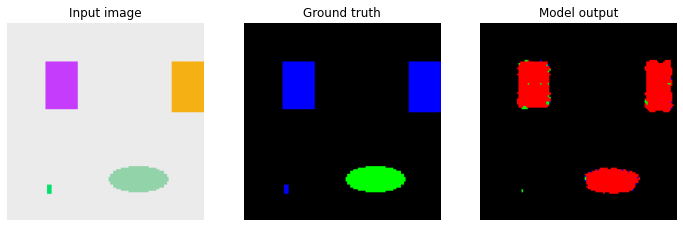

In [26]:
for batch_ind, (img, target) in enumerate(train_loader):
    # moving the image and GT to device
    img = img.to(device)
    target = target.to(device)
    output = model(img)
    break
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1)
ax.axis('off')
ax.imshow(img[0].detach().cpu().numpy().transpose(1, 2, 0) * std + mean)
ax.set_title('Input image')
ax = fig.add_subplot(1, 3, 2)
ax.axis('off')
ax.imshow(label2colour(target[0].detach().cpu().numpy()))
ax.set_title('Ground truth')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(label2colour(torch.argmax(output[0], dim=0).detach().cpu().numpy()))
ax.axis('off')
ax.set_title('Model output')

### Transfer learning

We define a new class for our network to use transfer learning. `TransferNet` uses the feature extraction from `resnet18` pretrained on ImageNet (object recognition).

**Question**: 
* extract features from `resnet18` at a different layer (shallower or deeper) how would the results change?
* extract fatures from a different pretrained network.

In [19]:
## creating model
class TransferNet(nn.Module):
    def __init__(self, num_classes: int, fine_tune=False) -> None:
        super().__init__()
        pretrained = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(pretrained.children())[:7])
        for p in self.features.parameters():
            p.requires_grad = fine_tune
        # features_kernels is the number of kernels from our pretrained network.
        features_kernels = 256
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(features_kernels, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Conv2d(16, num_classes, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # storing the spatial resolution of input
        size = x.shape[-2:]
        # the input x is processed with the network
        x = self.features(x)
        x = self.decoder(x)
        x = torch.nn.functional.interpolate(x, size=size, mode="bilinear", align_corners=False)
        x = self.classifier(x)
        return x

Training the `TreansferNet` under identical conditions as `SimpleNet`. We can observe that it obtains much higher accuracy. Suggesting pretrained weights has been useful for our segmentation task.

**Question**: plot the accuacy/loss of `SimpleNet` and `TransferNet` to have a better comparison.

In [20]:
# optimizer and criterion
transfer_model = TransferNet(len(labels_map), fine_tune=False).to(device)
params_to_optimize = [{'params': [p for p in transfer_model.parameters() if p.requires_grad]}]
momentum = 0.9
learning_rate = 0.1
weight_decay = 1e-4
optimizer = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

# doing epoch
epochs = 10
initial_epoch = 0
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}
for epoch in range(initial_epoch, epochs):
    train_log = epoch_loop(transfer_model, train_loader, criterion, optimizer)
    
    val_log = epoch_loop(transfer_model, val_loader, criterion, None)
    
    print('[%.2d] Train     loss=%.4f     acc=%0.2f    [%.2d] Test     loss=%.4f     acc=%0.2f' % 
          (
              epoch, np.mean(train_log[1]), np.mean(train_log[0]),
              epoch, np.mean(val_log[1]), np.mean(val_log[0])
          ))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[00] Train     loss=0.2710     acc=0.16    [00] Test     loss=0.1584     acc=0.40
[01] Train     loss=0.1352     acc=0.59    [01] Test     loss=0.1106     acc=0.74
[02] Train     loss=0.1015     acc=0.74    [02] Test     loss=0.0926     acc=0.75
[03] Train     loss=0.0915     acc=0.76    [03] Test     loss=0.0846     acc=0.79
[04] Train     loss=0.0894     acc=0.77    [04] Test     loss=0.0821     acc=0.76
[05] Train     loss=0.0817     acc=0.79    [05] Test     loss=0.0775     acc=0.78
[06] Train     loss=0.0800     acc=0.80    [06] Test     loss=0.0747     acc=0.79
[07] Train     loss=0.0780     acc=0.80    [07] Test     loss=0.0734     acc=0.83
[08] Train     loss=0.0735     acc=0.82    [08] Test     loss=0.0702     acc=0.86
[09] Train     loss=0.0720     acc=0.81    [09] Test     loss=0.0704     acc=0.80


## 5. Experiment With Noise

Let's experiment with a more complex dataset with noisy backgrounds.

In [33]:
bg_uniform_vs_noise = 0.5
train_dataset = ShapeDataset(1000, img_size, bg_uniform_vs_noise, transform=transform)

batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True, sampler=None
)

val_dataset = ShapeDataset(1000, img_size, bg_uniform_vs_noise, transform=transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True, sampler=None
)

### SimpleNet

In [34]:
# optimizer and criterion
model = SimpleNet(len(labels_map)).to(device)
params_to_optimize = [{'params': [p for p in model.parameters()]}]
momentum = 0.9
learning_rate = 0.1
weight_decay = 1e-4
optimizer = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

# doing epoch
epochs = 10
initial_epoch = 0
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}
for epoch in range(initial_epoch, epochs):
    train_log = epoch_loop(model, train_loader, criterion, optimizer)
    
    val_log = epoch_loop(model, val_loader, criterion, None)
    
    print('[%.2d] Train     loss=%.4f     acc=%0.2f    [%.2d] Test     loss=%.4f     acc=%0.2f' % 
          (
              epoch, np.mean(train_log[1]), np.mean(train_log[0]),
              epoch, np.mean(val_log[1]), np.mean(val_log[0])
          ))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[00] Train     loss=0.2983     acc=0.03    [00] Test     loss=0.3716     acc=0.35
[01] Train     loss=0.1865     acc=0.31    [01] Test     loss=0.1630     acc=0.33
[02] Train     loss=0.1564     acc=0.37    [02] Test     loss=0.1747     acc=0.34
[03] Train     loss=0.1462     acc=0.37    [03] Test     loss=0.1899     acc=0.37
[04] Train     loss=0.1664     acc=0.35    [04] Test     loss=0.1592     acc=0.34
[05] Train     loss=0.1443     acc=0.37    [05] Test     loss=0.1435     acc=0.35
[06] Train     loss=0.1371     acc=0.37    [06] Test     loss=0.1328     acc=0.37
[07] Train     loss=0.1387     acc=0.37    [07] Test     loss=0.1304     acc=0.39
[08] Train     loss=0.1319     acc=0.40    [08] Test     loss=0.1285     acc=0.41
[09] Train     loss=0.1328     acc=0.42    [09] Test     loss=0.1374     acc=0.42


Text(0.5, 1.0, 'Model output')

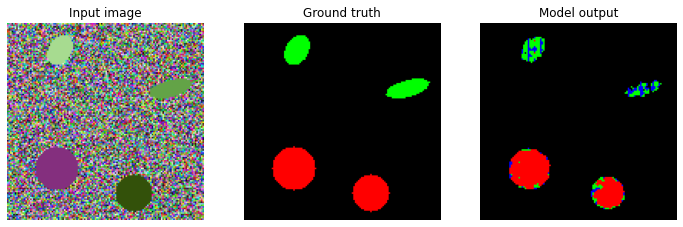

In [29]:
for batch_ind, (img, target) in enumerate(train_loader):
    # moving the image and GT to device
    img = img.to(device)
    target = target.to(device)
    output = model(img)
    break
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1)
ax.axis('off')
ax.imshow(img[0].detach().cpu().numpy().transpose(1, 2, 0) * std + mean)
ax.set_title('Input image')
ax = fig.add_subplot(1, 3, 2)
ax.axis('off')
ax.imshow(label2colour(target[0].detach().cpu().numpy()))
ax.set_title('Ground truth')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(label2colour(torch.argmax(output[0], dim=0).detach().cpu().numpy()))
ax.axis('off')
ax.set_title('Model output')

### TransferNet

In [24]:
# optimizer and criterion
transfer_model = TransferNet(len(labels_map)).to(device)
params_to_optimize = [{'params': [p for p in transfer_model.parameters() if p.requires_grad]}]
momentum = 0.9
learning_rate = 0.1
weight_decay = 1e-4
optimizer = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

# doing epoch
epochs = 10
initial_epoch = 0
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}
for epoch in range(initial_epoch, epochs):
    train_log = epoch_loop(transfer_model, train_loader, criterion, optimizer)
    
    val_log = epoch_loop(transfer_model, val_loader, criterion, None)
    
    print('[%.2d] Train     loss=%.4f     acc=%0.2f    [%.2d] Test     loss=%.4f     acc=%0.2f' % 
          (
              epoch, np.mean(train_log[1]), np.mean(train_log[0]),
              epoch, np.mean(val_log[1]), np.mean(val_log[0])
          ))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[00] Train     loss=0.2910     acc=0.04    [00] Test     loss=0.2203     acc=0.23
[01] Train     loss=0.2052     acc=0.28    [01] Test     loss=0.1863     acc=0.33
[02] Train     loss=0.1643     acc=0.47    [02] Test     loss=0.1448     acc=0.53
[03] Train     loss=0.1354     acc=0.59    [03] Test     loss=0.1172     acc=0.69
[04] Train     loss=0.1169     acc=0.69    [04] Test     loss=0.1113     acc=0.65
[05] Train     loss=0.1077     acc=0.71    [05] Test     loss=0.1052     acc=0.68
[06] Train     loss=0.1069     acc=0.72    [06] Test     loss=0.1035     acc=0.76
[07] Train     loss=0.1011     acc=0.74    [07] Test     loss=0.0976     acc=0.78
[08] Train     loss=0.1004     acc=0.73    [08] Test     loss=0.0988     acc=0.68
[09] Train     loss=0.0996     acc=0.74    [09] Test     loss=0.0947     acc=0.79


## Discussion

Overall, we observe that the pretrained network is useful for our segmentation task. **Questions**:
* We didn't fine-tune the pretrained weights. Play with that. Consider lower-learning-rate for those layers. How the results would change?
* Increase the complexity of your task (e.g., more geometrical shapes). Is the benefit of pretrained network more evident?